<a href="https://colab.research.google.com/github/allispaul/audiobot/blob/main/EDA/Audiobots_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Erd&#337;s Institute Fall Boot Camp - Team Audiobots

We're using data from [this dataset](hhttps://huggingface.co/datasets/lewtun/music_genres_small) to try and classify one thousand 30s samples of audio into one of 10 genres:

*   International        
*   Pop                  
*   Electronic           
*   Chiptune / Glitch    
*   Punk                 
*   Folk                 
*   Hip-Hop              
*   Rock                 
*   Instrumental         
*   Experimental

The data is a .parquet file containing ~30s (uncompressed?) .wav files (I have to check bit depths and sample rates still), along with song_id (does this mean anything to anyone?), and the genre from one of the 10 categories above.

We are assuming the genres are accurate. Notably, the ``International'' genre appears to contain a variety of other genres of music, and many songs can come from more than one genre. We may eliminate this class if it causes problems.

For training, we will feed the 90\% of the data into a pre-trained Transformer network from HuggingSpace, and fine-tune the network to classify one of the 10 genres above. If the architecture requries inputs of constant size, we can either pad shorter samples with 0's, or randomly clip shorter sections of longer audio streams.

This code does the following:

*   Downloads the data from Google Drive
*   (TODO) Splits the data into a CONSISTENT training and validation set. No need to create a test set until we get to the larger datasets.
*   Calculates statistics for each class, verifying the same number of tracks in each genre, and that the size of each song is similar.
*   (TODO) Determine if there's a way to analyze the average value/volume for each track.
*   (TODO) Do we want to normalize the data in any way? I suspect Electronic music will be consistently louder than Folk music, which could throw off a (dumb) model just by changing the volume.
*   (TODO) Create a simple model to predict genre from the data
*   (TODO) Turn the data into spectrograms. This should probably be done once and saved instead of on the fly, as different settings could produce drastically different pictures.

In [9]:
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Note: This links your Google Drive to Colab. Useful if the data is stored in Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Alternatively, you can download the data from scratch

In [1]:
# !wget https://huggingface.co/datasets/lewtun/music_genres_small/resolve/main/data/train-00000-of-00001-63d68663287b1638.parquet?download=true

--2024-02-23 20:52:50--  https://huggingface.co/datasets/lewtun/music_genres_small/resolve/main/data/train-00000-of-00001-63d68663287b1638.parquet?download=true
Resolving huggingface.co (huggingface.co)... 65.8.178.118, 65.8.178.12, 65.8.178.93, ...
Connecting to huggingface.co (huggingface.co)|65.8.178.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/7d/36/7d36780ef7f5dbd22e4ae2ff5028f5101c93ca9b418b3b0aa84d838dd7d393fb/bed1e08f92cfef798398a7183a23da725ccbf503bc91f45a865749511218f035?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27train-00000-of-00001-63d68663287b1638.parquet%3B+filename%3D%22train-00000-of-00001-63d68663287b1638.parquet%22%3B&Expires=1708980771&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwODk4MDc3MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy83ZC8zNi83ZDM2NzgwZWY3ZjVkYmQyMmU0YWUyZmY1MDI4ZjUxMDFjOTNjYTliNDE4YjNi

In [4]:
PATH_TO_DATA = "/content/drive/MyDrive/Colab Notebooks/Erdos Institute Boot Camp/Audiobots/Data/data.parquet"

In [6]:
df = pq.read_table(PATH_TO_DATA).to_pandas()
df.head()

,audio,song_id,genre_id,genre
0,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,11483,9,International
1,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,6824,9,International
2,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,8361,8,Pop
3,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,12269,9,International
4,{'bytes': b'OggS\x00\x02\x00\x00\x00\x00\x00\x...,1063,0,Electronic


In [34]:
df.genre_id.value_counts()

9    100
8    100
0    100
6    100
2    100
5    100
4    100
1    100
7    100
3    100
Name: genre_id, dtype: int64

In [61]:
df.genre.value_counts()

International        100
Pop                  100
Electronic           100
Chiptune / Glitch    100
Punk                 100
Folk                 100
Hip-Hop              100
Rock                 100
Instrumental         100
Experimental         100
Name: genre, dtype: int64

(array([100.,   0., 100.,   0., 100.,   0., 100.,   0., 100.,   0., 100.,
          0., 100.,   0., 100.,   0., 100.,   0., 100.]),
 array([0.        , 0.47368421, 0.94736842, 1.42105263, 1.89473684,
        2.36842105, 2.84210526, 3.31578947, 3.78947368, 4.26315789,
        4.73684211, 5.21052632, 5.68421053, 6.15789474, 6.63157895,
        7.10526316, 7.57894737, 8.05263158, 8.52631579, 9.        ]),
 <BarContainer object of 19 artists>)

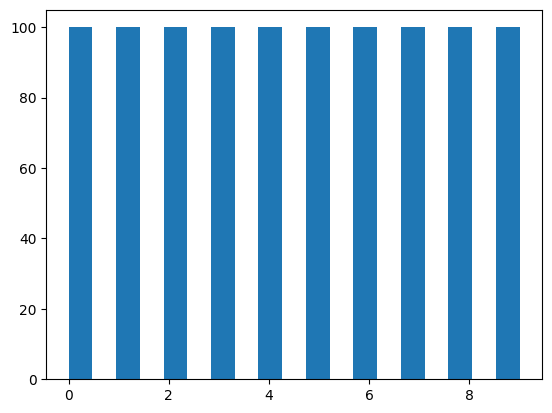

In [33]:
plt.hist(df.genre_id, bins = 19)

In [15]:
df.describe()

,song_id,genre_id
count,1000.000000,1000.000000
mean,12344.531000,4.500000
std,7382.361901,2.873719
min,2.000000,0.000000
25%,5789.750000,2.000000
50%,12340.500000,4.500000
75%,18724.250000,7.000000
max,24971.000000,9.000000


In [46]:
df.audio[0].keys()


dict_keys(['bytes', 'path'])

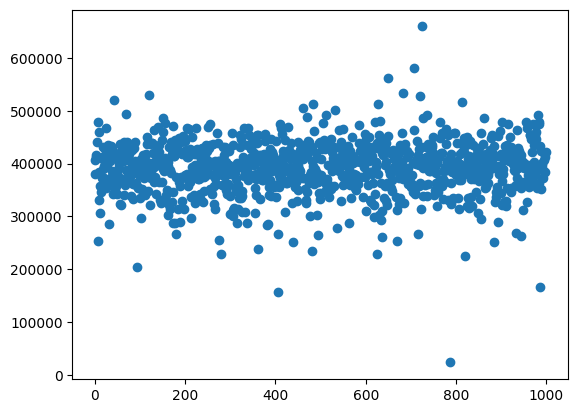

In [57]:
lengths = []

for sample in df.audio:
    lengths.append(len(sample['bytes']))

plt.scatter(range(1000),lengths)

In [60]:
print("Longest song (bytes?)", max(lengths))
print("Shortest song (bytes?)", min(lengths))
print("Average song (bytes?)", np.mean(lengths))

Longest song (bytes?) 659948
Shortest song (bytes?) 23181
Average song (bytes?) 391207.36


This could technically be an issue if whatever architecture we're using requires a constant length input.

If so, we could always pad with zeros, or randomly sample 23181 bytes(?) from every longer track.